## Initialization

In [92]:
#!pip install opencv-python
import os # For directories 
import numpy as np 
import pandas as pd
from skimage import io 
from skimage.io import imread
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage.filters import difference_of_gaussians
from scipy import misc
import matplotlib as mpl 
import matplotlib.pyplot as plt 
%matplotlib inline 
import matplotlib.patches as mpatches
import seaborn as sns; sns.set()  
import ipywidgets as widgets 
from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout
from ipywidgets.embed import embed_minimal_html, dependency_state
from scipy import stats
from scipy.optimize import curve_fit
from pathlib import Path, PureWindowsPath # for working with windows paths
import tifffile # library to store numpy arrays in TIFF
import cv2 # to label connected components in binarized images 

## Step 0: Choose Directoy, File, & Set Independent Variables

In [2]:
working_directory = r"X:\Hunter\FRAP_Movie"
filename = r"Tag_scFv_FRAP8488.tif"

In [3]:
# Parameters needed for describing the FRAP experiment
pixel_size = 0.130          #microns; 130nm for flexie and ## on confocal
dt1 = 0.1                   #seconds; the time between frames right after FRAP at faster post-FRAP frame rate
dt2 = 5                     #seconds; the time between frames at slower post-FRAP frame rate
change_t_frame_num = 50     #unitless; the frame number at which the frame rate changes from dt1 to dt2 
frap_frame_num = 20         #unitless; the frame number at which you did the FRAP photobleach
bleach_dt = 0.1             #seconds; the time it took to do the FRAP
radial_bin_size = 2         #pixels; the width in pixels of concentric rings that describe the FRAP spot through time
buffer = 3                  #not sure right now
fit_up_to = 6               #how many concentric rings around FRAP spot to fit
frap_channel = 0            #0 for single-channel movie; 1 or 2 for two-channel movie

# Step 1: Find position of cell and FRAP spot; subtract background

In [6]:
vid = imread(os.path.join(working_directory,filename)) 

In [9]:
(frame_num, dim_x, dim_y) = vid.shape
[frame_num, dim_x, dim_y]

[169, 928, 624]

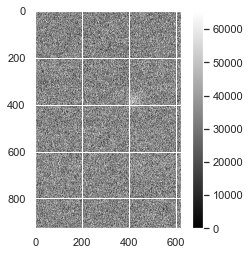

In [20]:
# To estimate where the FRAP occurred, we will take the difference between the FRAP frame and the previous frame:
# colormap options are: 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean',
diff_arr = vid[frap_frame_num]-vid[frap_frame_num-1] #Difference between FRAP frame and previous frame
plt.figure(figsize=(4,4))
plt.imshow(diff_arr,cmap= 'gray')  
plt.colorbar()
plt.show()

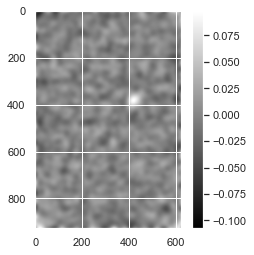

In [32]:
# Performing difference of gaussian to accentuate FRAP spot
filtered_arr = difference_of_gaussians(diff_arr, 12, 40)
plt.figure(figsize=(4,4))
plt.imshow(filtered_arr,cmap= 'gray')  
plt.colorbar()
plt.show()

In [37]:
# Finding the intensity of pixels in the 99% percentile (top 1% of pixels by brightness)
frap_threshhold = np.quantile(filtered_arr,0.99)

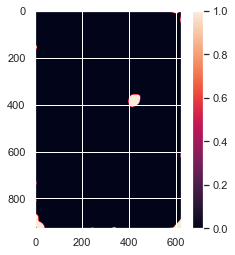

In [68]:
binarized_arr = filtered_arr
binarized_arr[filtered_arr < frap_threshhold] = 0
binarized_arr[filtered_arr >= frap_threshhold] = 1
plt.figure(figsize=(4,4))
plt.imshow(binarized_arr)  
plt.colorbar()
plt.show()

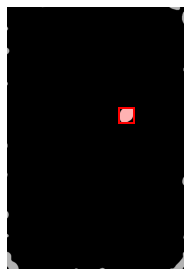

In [94]:
# remove artifacts connected to image border
cleared = clear_border(binarized_arr)

# label image regions
label_image = label(cleared)

# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=filtered_arr, bg_label=0)

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [99]:
[region.bbox for region in regionprops(label_image)]

[(359, 396, 413, 447)]